# Part 2: Advanced Configuration

In [1]:
from tensorflow.keras.utils import to_categorical
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt
import plotting
import pprint
%matplotlib inline

## Load the dataset

In [2]:
#Fetch the data
data = fetch_openml('hls4ml_lhc_jets_hlf')
X, y = data['data'], data['target']

#One-hot encode labels
le = LabelEncoder()
y = le.fit_transform(y)
y = to_categorical(y, 5)

#Split into training and testing data set
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Standardize input
scaler = StandardScaler().fit(X_train_val)
X_train_val = scaler.transform(X_train_val)
X_test = scaler.transform(X_test)

## Load the model
Load the model trained in [part1_getting_started](./part1_getting_started.ipynb). **Make sure you've run through that walkthrough first!**

In [3]:
from tensorflow.keras.models import load_model
model = load_model('model_1/KERAS_check_best_model.h5')

## Make an hls4ml config & model
This time, we'll create a config with finer granularity. When we print the config dictionary, you'll notice that an entry is create for each named Layer of the model. See for the first layer, for example:
```LayerName:
    fc1:
        Precision:
            weight: ap_fixed<16,6>
            bias:   ap_fixed<16,6>
            result: ap_fixed<16,6>
        ReuseFactor: 1
```
Taken 'out of the box' this config will set all the parameters to the same settings as in part 1, but we can use it as a template to start modifying things. 

In [4]:
import hls4ml
config = hls4ml.utils.config_from_keras_model(model, granularity='name')

print()
print("Configuration:")
pprint.pprint(config)

Interpreting Sequential
Topology:
Layer name: fc1, layer type: Dense
  -> Activation (linear), layer name: fc1
Layer name: relu1, layer type: Activation
Layer name: fc2, layer type: Dense
  -> Activation (linear), layer name: fc2
Layer name: relu2, layer type: Activation
Layer name: fc3, layer type: Dense
  -> Activation (linear), layer name: fc3
Layer name: relu3, layer type: Activation
Layer name: output, layer type: Dense
  -> Activation (linear), layer name: output
Layer name: softmax, layer type: Activation

Configuration:
{'LayerName': {'fc1': {'Precision': {'bias': 'ap_fixed<16,6>',
                                     'result': 'ap_fixed<16,6>',
                                     'weight': 'ap_fixed<16,6>'},
                       'ReuseFactor': 1},
               'fc1_linear': {'Precision': 'ap_fixed<16,6>',
                              'ReuseFactor': 1,
                              'table_size': 1024,
                              'table_t': 'ap_fixed<18,8>'},
           

## Customize
Let's just try setting the precision of the first layer weights to something very small. Using fewer bits can save resources in the FPGA firmware.

Then create the `HLSModel` and display the architecture. Notice the weights of the first layer now have a different precision.

Interpreting Sequential
Input shape: [16]
Topology:
Layer name: fc1, layer type: Dense, current shape: [[None, 16]]
Layer name: relu1, layer type: Activation, current shape: [[None, 64]]
Layer name: fc2, layer type: Dense, current shape: [[None, 64]]
Layer name: relu2, layer type: Activation, current shape: [[None, 32]]
Layer name: fc3, layer type: Dense, current shape: [[None, 32]]
Layer name: relu3, layer type: Activation, current shape: [[None, 32]]
Layer name: output, layer type: Dense, current shape: [[None, 32]]
Layer name: softmax, layer type: Softmax, current shape: [[None, 5]]
Creating HLS model


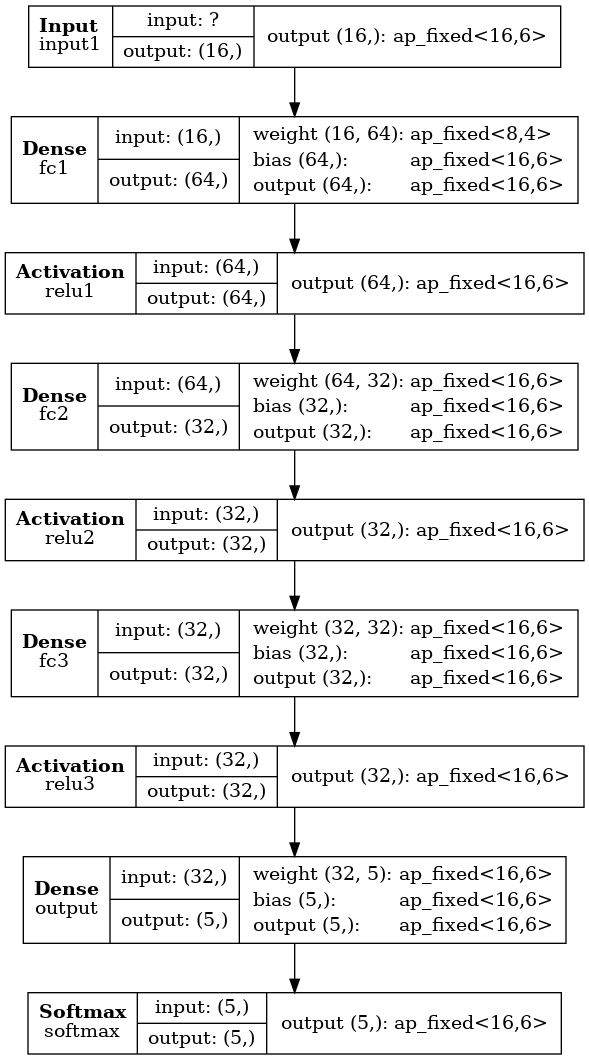

In [5]:
config['LayerName']['fc1']['Precision']['weight'] = 'ap_fixed<8,4>'
hls_model = hls4ml.converters.convert_from_keras_model(model, hls_config=config, output_dir='model_1/hls4ml_prj_2')
hls4ml.utils.plot_model(hls_model, show_shapes=True, show_precision=True, to_file=None)

## Compile, predict
Now we need to check that this model performance is still good. We compile the hls_model, and then use `hls_model.predict` to execute the FPGA firmware with bit-accurate emulation on the CPU.

In [6]:
hls_model.compile()
y_hls = hls_model.predict(X_test)

Writing HLS project
Done


## Compare
Let's see if we lost performance by using 8 bits for the weights.

Keras  Accuracy: 0.7507469879518073
hls4ml Accuracy: 0.7087951807228916


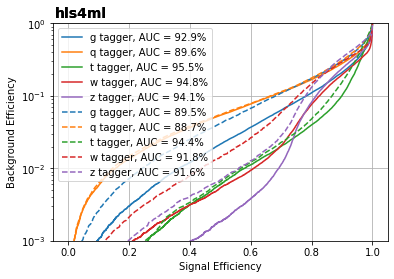

In [7]:
print("Keras  Accuracy: {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(model.predict(X_test), axis=1))))
print("hls4ml Accuracy: {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_hls, axis=1))))

#Plot ROC curve
plt.figure()
_ = plotting.makeRoc(X_test, y_test, le.classes_, model)
plt.gca().set_prop_cycle(None) # reset the colors
_ = plotting.makeRoc(X_test, y_test, le.classes_, hls_model, linestyle='--')

## Summary
It looks like we lost some accuracy compared to Keras, while when we used `ap_fixed<16,6>` the accuracy matched Keras well. The QKeras and "profiling" exercises will show how we can tune the precision without losing much performance.

## ReuseFactor
Now let's look at the other configuration parameter: `ReuseFactor`.
Recall that `ReuseFactor` is our mechanism for tuning the parallelism:

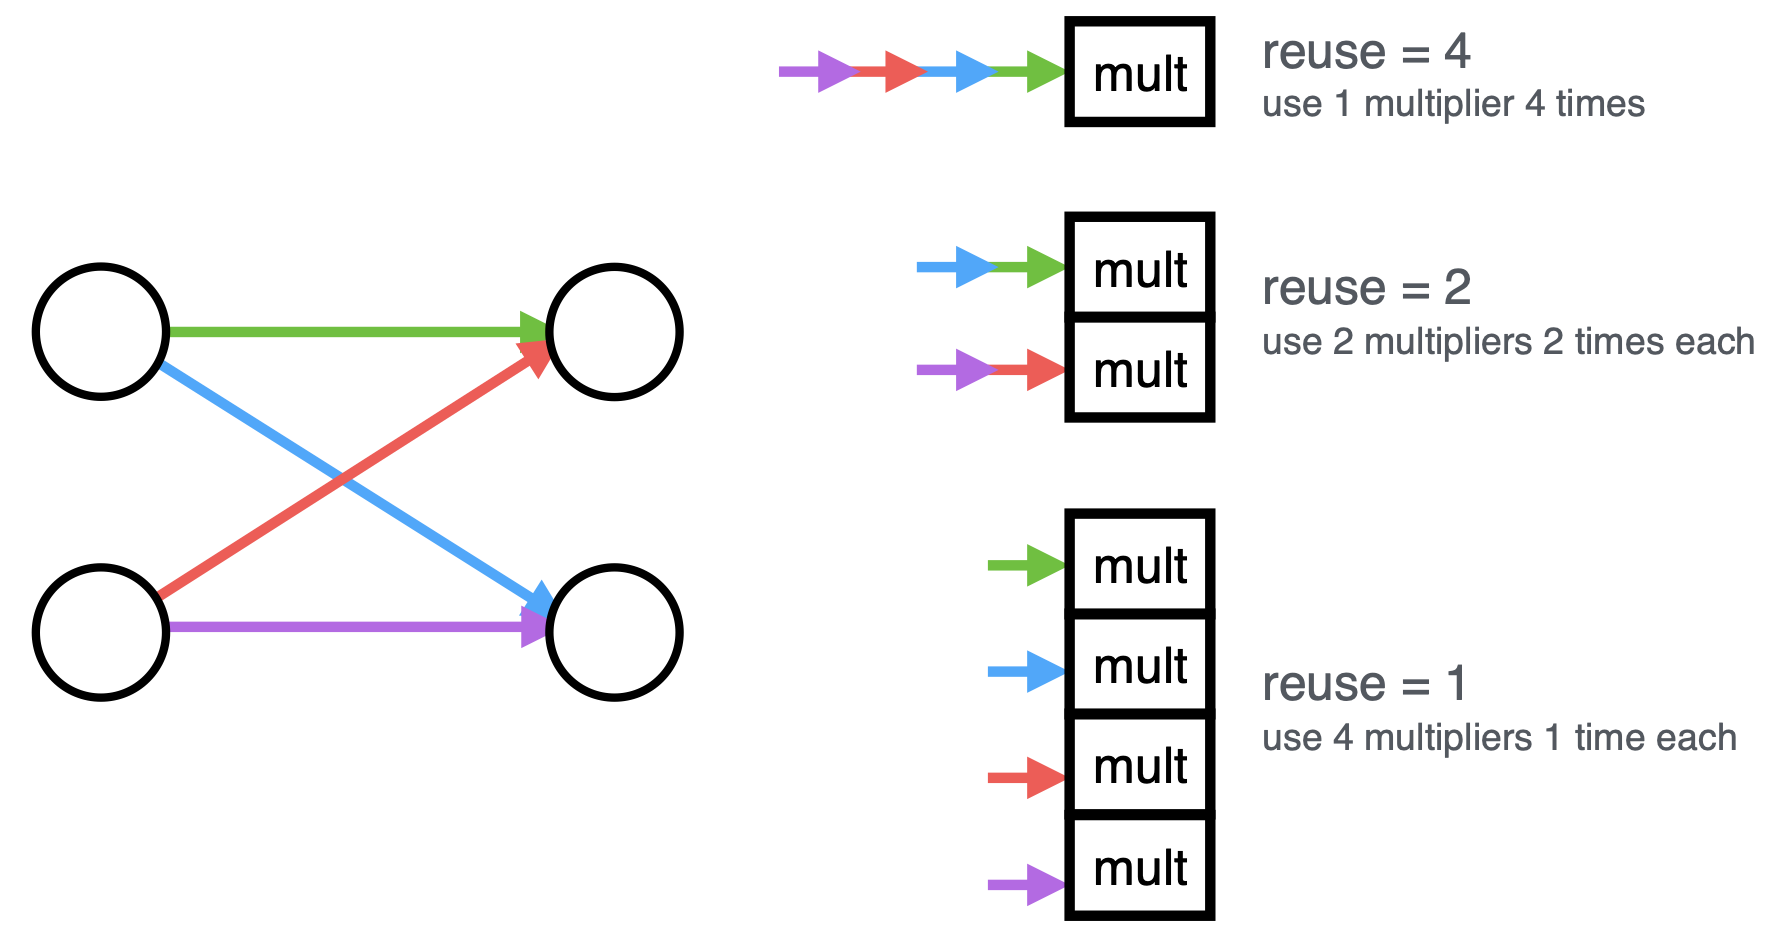

So now let's make a new configuration for this model, and set the `ReuseFactor` to `2` for every layer:
We'll compile the model, then evaulate its performance. Changing the `ReuseFactor` should not change the classification results, so let's just verify that!
Then we'll build the model.

Interpreting Sequential
Topology:
Layer name: fc1, layer type: Dense
  -> Activation (linear), layer name: fc1
Layer name: relu1, layer type: Activation
Layer name: fc2, layer type: Dense
  -> Activation (linear), layer name: fc2
Layer name: relu2, layer type: Activation
Layer name: fc3, layer type: Dense
  -> Activation (linear), layer name: fc3
Layer name: relu3, layer type: Activation
Layer name: output, layer type: Dense
  -> Activation (linear), layer name: output
Layer name: softmax, layer type: Activation

Configuration:
{'Model': {'Precision': 'ap_fixed<16,6>',
           'ReuseFactor': 1,
           'Strategy': 'Latency'}}

Interpreting Sequential
Input shape: [16]
Topology:
Layer name: fc1, layer type: Dense, current shape: [[None, 16]]
Layer name: relu1, layer type: Activation, current shape: [[None, 64]]
Layer name: fc2, layer type: Dense, current shape: [[None, 64]]
Layer name: relu2, layer type: Activation, current shape: [[None, 32]]
Layer name: fc3, layer type: Dense, c

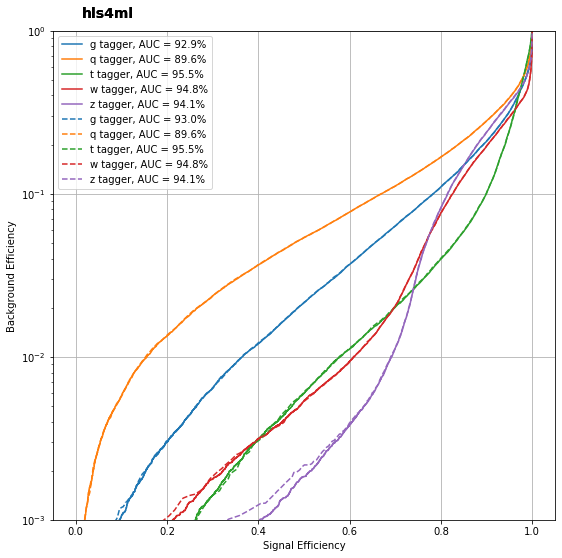

In [8]:
config = hls4ml.utils.config_from_keras_model(model, granularity='Model')

print()
print("Configuration:")
pprint.pprint(config)
print()

#Set Re-use factor to 2 for every layer
config['Model']['ReuseFactor'] = 2

#Convert to hls model and recompile it
hls_model = hls4ml.converters.convert_from_keras_model(model, hls_config=config, output_dir='model_1/hls4ml_prj_3')
hls_model.compile()

#Get the output again
y_hls = hls_model.predict(X_test)

#Calculate accuracy
print("Keras  Accuracy: {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(model.predict(X_test), axis=1))))
print("hls4ml Accuracy: {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_hls, axis=1))))

#Plot ROC cuve of the new output
plt.figure(figsize=(9, 9))
_ = plotting.makeRoc(X_test, y_test, le.classes_, model)
plt.gca().set_prop_cycle(None) # reset the colors
_ = plotting.makeRoc(X_test, y_test, le.classes_, hls_model, linestyle='--')

Now build the model

In [9]:
hls_model.build()

And now print the report, compare this to the report from Exercise 1

In [10]:
hls4ml.report.read_vivado_report('model_1/hls4ml_prj_3')

Found 1 solution(s) in model_1/hls4ml_prj_3/myproject_prj.
Reports for solution "solution1":

C SIMULATION RESULT:
INFO: [SIM 2] *************** CSIM start ***************
INFO: [SIM 4] CSIM will launch GCC as the compiler.
   Compiling ../../../../myproject_test.cpp in debug mode
   Compiling ../../../../firmware/myproject.cpp in debug mode
   Generating csim.exe
INFO: Unable to open input/predictions file, using default input.
0.0380859 0.0986328 0.119141 0.605469 0.163086 
INFO: Saved inference results to file: tb_data/csim_results.log
INFO: [SIM 1] CSim done with 0 errors.
INFO: [SIM 3] *************** CSIM finish ***************

SYNTHESIS REPORT:
== Vivado HLS Report for 'myproject'
* Date:           Mon Jun  8 09:48:34 2020

* Version:        2018.2 (Build 2258646 on Thu Jun 14 20:25:20 MDT 2018)
* Project:        myproject_prj
* Solution:       solution1
* Product family: kintexu
* Target device:  xcku115-flvb2104-2-i


== Performance Estimates
+ Timing (ns): 
    * Summary: 
 

In [11]:
hls4ml.report.read_vivado_report('model_1/hls4ml_prj')

Found 1 solution(s) in model_1/hls4ml_prj/myproject_prj.
Reports for solution "solution1":

C SIMULATION RESULT:
INFO: [SIM 2] *************** CSIM start ***************
INFO: [SIM 4] CSIM will launch GCC as the compiler.
   Compiling ../../../../myproject_test.cpp in debug mode
   Compiling ../../../../firmware/myproject.cpp in debug mode
   Generating csim.exe
INFO: Unable to open input/predictions file, using default input.
0.0380859 0.0986328 0.119141 0.605469 0.163086 
INFO: Saved inference results to file: tb_data/csim_results.log
INFO: [SIM 1] CSim done with 0 errors.
INFO: [SIM 3] *************** CSIM finish ***************

SYNTHESIS REPORT:
== Vivado HLS Report for 'myproject'
* Date:           Mon Jun  8 08:44:05 2020

* Version:        2018.2 (Build 2258646 on Thu Jun 14 20:25:20 MDT 2018)
* Project:        myproject_prj
* Solution:       solution1
* Product family: kintexu
* Target device:  xcku115-flvb2104-2-i


== Performance Estimates
+ Timing (ns): 
    * Summary: 
   

## Exercise
- Recall the outcome of the exercise of part 1 where we estimated how many DSPs our network should use.
How does this change now we've used `ReuseFactor = 2` for the network? Does the expectation match the report this time?

## (Optional) Profiling
As we saw, we can choose the precision of _everything_ in our Neural Network. This is a powerful way to tune the performance, but it's also complicated. The tools in `hls4ml.model.profiling` can help you choose the right precision for your model. That said, training your model with quantization built in can get around this problem, and that is introduced in part 4. So, don't go too far down the rabbit hole of tuning your data types without first trying out quantization-aware-training with QKeras.

The first thing to try is to numerically profile your model. This method plots the distribution of the weights (and biases) as a box and whisker. The grey boxes shows the values which can be represented with the data types used in the `hls_model`. Generally, you need the box to overlap completely with the whisker 'to the right' (large values) otherwise you'll get saturation & wrap-around issues. It can be okay for the box not to overlap completely 'to the left' (small values), but finding how small you can go is a matter of trial-and-error.

Providing data, in this case just using the first 1000 examples for speed, will show the same distributions captured at the output of each layer.

Profiling weights
Profiling activations
   fc1
   relu1
   fc2
   relu2
   fc3
   relu3
   output
   softmax


(<Figure size 432x288 with 1 Axes>, <Figure size 432x288 with 1 Axes>)

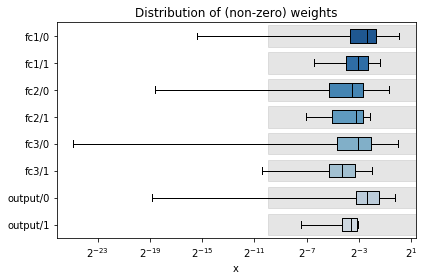

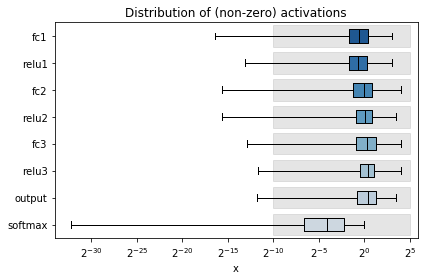

In [12]:
hls4ml.model.profiling.numerical(keras_model=model, hls_model=hls_model, X=X_test[:1000])

## Trace
If you have used very customised precision throughout the model, it can be useful to get the output from each layer to find out when things have gone wrong.
This returns a dictionary with keys corresponding to the layer names of the model. Stored at that key is the array of values output by that layer, sampled from the provided data.
A helper function `get_ymodel_keras` will return the same dictionary for the Keras model.

In [36]:
config = hls4ml.utils.config_from_keras_model(model, granularity='Model')
config['Model']['Trace'] = True

print()
print("Configuration:")
print(config)
print()

hls_model = hls4ml.converters.convert_from_keras_model(model, hls_config=config, output_dir='model_1/hls4ml_prj_3')
hls_model.compile()

hls4ml_pred, hls4ml_trace = hls_model.trace(X_test[:1000])
keras_trace = hls4ml.model.profiling.get_ymodel_keras(model, X_test[:1000])

Interpreting Sequential
Topology:
Layer name: fc1, layer type: Dense
  -> Activation (linear), layer name: fc1
Layer name: relu1, layer type: Activation
Layer name: fc2, layer type: Dense
  -> Activation (linear), layer name: fc2
Layer name: relu2, layer type: Activation
Layer name: fc3, layer type: Dense
  -> Activation (linear), layer name: fc3
Layer name: relu3, layer type: Activation
Layer name: output, layer type: Dense
  -> Activation (linear), layer name: output
Layer name: softmax, layer type: Activation

Configuration:
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency', 'Trace': True}}

Interpreting Sequential
Input shape: [16]
Topology:
Layer name: fc1, layer type: Dense, current shape: [[None, 16]]
Layer name: relu1, layer type: Activation, current shape: [[None, 64]]
Layer name: fc2, layer type: Dense, current shape: [[None, 64]]
Layer name: relu2, layer type: Activation, current shape: [[None, 32]]
Layer name: fc3, layer type: Dense, current 

TypeError: decoding to str: need a bytes-like object, NoneType found

In [48]:
!pwd

/home/dhoang/hls4ml-tutorial/model_1/hls4ml_prj_3/firmware/model_1/hls4ml_prj_3/firmware/model_1/hls4ml_prj_3/firmware/model_1/hls4ml_prj_3/firmware/model_1/hls4ml_prj_3/firmware/model_1/hls4ml_prj_3/firmware/model_1/hls4ml_prj_3/firmware/model_1/hls4ml_prj_3/firmware/model_1/hls4ml_prj_3/firmware/model_1/hls4ml_prj_3/firmware/model_1/hls4ml_prj_3/firmware/model_1/hls4ml_prj_3/firmware
